## set up

In [1]:
# imports
import numpy as np
import os
from os import path

from scipy.signal import convolve


import matplotlib.pyplot as plt
import scipy.sparse.linalg as ssl
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *
import sys
sys.path.insert(0,'../scripts/')
from calibrate import calibrate
from time import time
from pylops.signalprocessing import Fredholm1

ModuleNotFoundError: No module named 'calibrate'

In [3]:
import pylops

In [4]:
print(pylops.__version__)

1.18.3


In [5]:
#load full data for test
datapath = '../data'
inputfile = os.path.join(datapath, 'input_full_v2.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1750.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

method = 'src_ana'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 1100, 0.003
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

# Data
p = inputdata['p']
vz = inputdata['vz']

p = np.apply_along_axis(convolve, 1, p, wav, mode='full')
p = p[:, wav_c:][:, :nt]
vz = np.apply_along_axis(convolve, 1, vz, wav, mode='full')
vz = vz[:, wav_c:][:, :nt]

# Normalize
vz /= p.max()
p /= p.max()

R1 = inputdata['vzmdd1']

In [6]:
# load data
datapath = '../data'
inputfile = os.path.join(datapath, 'input_full.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1750.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

method = 'src_ana'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]
# load data
datapath = '../data'
inputfile = os.path.join(datapath, 'input_full.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1750.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

method = 'src_ana'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 1100, 0.003
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

# Data
p = inputdata['p']
vz = inputdata['vz']

p = np.apply_along_axis(convolve, 1, p, wav, mode='full')
p = p[:, wav_c:][:, :nt]
vz = np.apply_along_axis(convolve, 1, vz, wav, mode='full')
vz = vz[:, wav_c:][:, :nt]

# Normalize
vz /= p.max()
p /= p.max()

In [7]:
# gen pup pdown
if path.exists(datapath + f'/updown_{method}.npz'):
    tmp_dict = np.load(datapath + f'/updown_{method}.npz')
    pup = tmp_dict['pup']
    pdown = tmp_dict['pdown']
else:
    #fft
    nfft=2**11
    FFTop = FFT2D(dims=[nr, nt], 
                  nffts=[nfft, nfft], sampling=[dr, dt])
    dottest(FFTop, nfft*nfft, nt*nr, complexflag=2)

    critical = 0.9
    ntaper = 9 # 7
    cutoff = 1e7 # 1e8

    #obliquity factor
    [Kx, F] = np.meshgrid(FFTop.f1, FFTop.f2, indexing='ij')
    k=F/vel_sep
    Kz=np.sqrt((k**2-Kx**2).astype(complex))
    Kz[np.isnan(Kz)] = 0

    # obliquities
    OBL=rho_sep*(np.abs(F)/Kz)
    OBL[Kz==0]=0
    OBL[OBL>cutoff]=0

    OBL1 = Kz /(rho_sep*np.abs(F))
    OBL1[F==0] = 0
    OBL1[OBL1<1./cutoff]=0

    # cut off and taper
    mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
    mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=0)
    mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=1)

    OBL = OBL*mask
    OBL1 = OBL1*mask

    # analytical separation
    Maskop = Diagonal(mask.ravel(), dtype='complex128')
    OBLop = Diagonal(OBL.ravel(), dtype='complex128')

    Sop = 0.5*(BlockDiag([FFTop.H, FFTop.H])*\
        Block([[Maskop, OBLop],
               [Maskop, -OBLop]])*\
               BlockDiag([FFTop, FFTop]))
    
    # calibration params
    twin = [0.01, 0.07]
    nfilt = 15

    pup = np.zeros((ns, nt, nr))
    pdown = np.zeros((ns, nt, nr))

    if method == 'sum':
        for isrc in range(0,ns):
            if isrc % 10 == 0:
                print(f'Working with source {isrc}/{ns}')
            vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                                rho_sep, twin=twin, nfilt=nfilt, plotflag=False)

            pdown[isrc] = (p[isrc] + vzcalib.T*(rho_sep*vel_sep) ) / 2.
            pup[isrc] = (p[isrc] - vzcalib.T*(rho_sep*vel_sep) ) / 2.

    elif method == 'src_ana':
        for isrc in range(0,ns):
            if isrc % 10 == 0:
                print(f'Working with source {isrc}/{ns}')
            vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                                rho_sep, twin=twin, nfilt=nfilt, plotflag=False)

            d = np.concatenate((p[isrc].T.ravel(), vzcalib.ravel()))
            dud = np.real(Sop*d)

            d = d.reshape(2*nr, nt)
            dud = dud.reshape(2*nr, nt)
            pdown[isrc], pup[isrc] = dud[:nr].T, dud[nr:].T

    elif method == 'rec_ana':
        for irec in range(nr):
            if irec % 10 == 0:
                print(f'Working with receiver {irec}/{nr}')

            vzcalib = calibrate(p[..., irec], vz[..., irec], r, s, irec, dt, nt, vel_dir, vel_sep, rho_sep,
                                twin=twin, nfilt=nfilt, plotflag=False)

            d = np.concatenate((p[...,irec].ravel(), vzcalib.ravel()))
            dud = np.real(Sop*d)

            d = d.reshape(2*ns, nt)
            dud = dud.reshape(2*ns, nt)
            pdown[...,irec], pup[...,irec] = dud[:ns], dud[ns:]

    elif method == 'src_inv':
        for isrc in range(ns):
            if isrc % 10 == 0:
                print(f'Working with source {isrc}/{ns}')
            vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                                rho_sep, twin=twin, nfilt=nfilt, plotflag=False)

            # separation by inversion
            OBLop = Diagonal(OBL1.flatten(), dtype='complex128')
            Maskop = Diagonal(mask.flatten(), dtype='complex128')

            S1op_scaled = (BlockDiag([FFTop.H, (p[isrc].max()/vzcalib.max())*FFTop.H])*\
                    Block([[Maskop, Maskop],
                           [OBLop, -OBLop]]) * BlockDiag([FFTop, FFTop]))

            d = np.concatenate((FFTop.H * Maskop * FFTop * p[isrc].T.flatten(), 
                                (p[isrc].max()/vzcalib.max()) * FFTop.H * Maskop * FFTop * vzcalib.flatten()))

            dud_inv, istop, itn, r1norm, r2norm = \
                lsqr(S1op_scaled, d.flatten(), damp=1e-10, 
                     iter_lim=10, show=0)[0:5]
            dud_inv = np.real(dud_inv)
            dud_inv = dud_inv.reshape(2*nr, nt)

            pdown_inv, pup_inv= dud_inv[:nr], dud_inv[nr:]

            # clean up data outside of spectral cone
            pdown_inv = np.real(np.reshape(FFTop.H * Maskop * FFTop * pdown_inv.ravel(), (nr, nt)))
            pup_inv = np.real(np.reshape(FFTop.H * Maskop * FFTop * pup_inv.ravel(), (nr, nt)))

            # clean up data outside of spectral cone
            pdown[isrc] = pdown_inv.T
            pup[isrc] = pup_inv.T
    np.savez(os.path.join(datapath, 'updown_%s' % method), pup=pup, pdown=pdown)

In [8]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0))).astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0))).astype('float32')
ntpad = pup.shape[1]

# nfmax=200

# fig, axs = plt.subplots(1, 2, figsize=(9,6))
# axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
#               extent = (r[0, 0], r[0,-1], t[-1], t[0]))
# axs[0].set_title(r'$pup$')
# axs[0].axis('tight')
# axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
#               extent = (r[0,0], r[0,-1], t[-1], t[0]))
# axs[1].set_title(r'$pdown$')
# axs[1].axis('tight');

In [9]:
#set up MCD
G = pdown.transpose(0, 2, 1).copy()
d = pup.transpose(0, 2, 1).copy()

twosided = 0
saveGt = 1
fftengine="numpy"
iter_lim=20

ncp = get_array_module(d)

ns, nr, nt = G.shape

nfmax=200

if len(d.shape) == 2:
    nv = 1
else:
    nv = d.shape[1]
# nv = 1
nt2 = nt
nfmax_allowed = nt 
# Fix nfmax to be at maximum equal to half of the size of fft samples
if nfmax is None or nfmax > nfmax_allowed:
    nfmax = nfmax_allowed
    logging.warning("nfmax set equal to ceil[(nt+1)/2=%d]" % nfmax)
    
# Bring kernel to frequency domain
Gfft = np.fft.rfft(G, nt2, axis=-1)
Gfft = Gfft[..., :nfmax]

# Bring frequency/time to first dimension
Gfft = np.moveaxis(Gfft, -1, 0)
d = np.moveaxis(d, -1, 0)

In [10]:
#ops
def ops(nt,nv,ns,nr):
    from pylops import Identity
    from pylops.signalprocessing import FFT

    nfft = int(np.ceil((nt + 1) / 2))
    Iop = Identity(
        N=nfmax * nr * nv, M=nfft * nr * nv, inplace=True, dtype='float64')
    I1op = Identity(
        N=nfmax * ns * nv, M=nfft * ns * nv, inplace=True, dtype='float64')
    I1opH = I1op.H

    Fop = FFT(dims=(nt, nr, nv), dir=0, real=True, ifftshift_before=twosided, engine = 'numpy')
    F1op = FFT(
        dims=(nt, ns, nv),
        dir=0,
        real=True,
        ifftshift_before=False,
        engine = 'numpy')
    F1opH = F1op.H
    Iop_com = Identity(N=nfmax * nr * nv, M=nfft * nr * nv, inplace=True, dtype=complex)
    I1op_com = Identity(N=nfmax * ns * nv, M=nfft * ns * nv, inplace=True, dtype=complex)
    I1opH_com = I1op_com.H
    return Iop_com, Fop, I1opH_com, F1opH
# Fredholm
import numpy as np

from pylops import LinearOperator
from pylops.utils.backend import get_array_module


class Fredholm1(LinearOperator):
    def __init__(self, G, nz=1, saveGt=True, usematmul=True, dtype="float64"):
        self.nz = nz
        self.nsl, self.nx, self.ny = G.shape
        self.G = G
        if saveGt:
            self.GT = G.transpose((0, 2, 1)).conj()
        self.usematmul = usematmul
        self.shape = (self.nsl * self.nx * self.nz, self.nsl * self.ny * self.nz)
        self.dtype = np.dtype(dtype)
        self.explicit = False

    def _matvec(self, x):
        ncp = get_array_module(x)
#         x = ncp.squeeze(x.reshape(self.nsl, self.ny, self.nz))
        x = x.reshape(self.nsl, self.ny, self.nz)
        if self.usematmul:
            if self.nz == 1:
                x = x[..., ncp.newaxis]
            y = ncp.matmul(self.G, x)
        else:
#             y = ncp.squeeze(ncp.zeros((self.nsl, self.nx, self.nz), dtype=self.dtype))
            y = ncp.zeros((self.nsl, self.nx, self.nz), dtype=self.dtype)
            for isl in range(self.nsl):
                y[isl] = ncp.dot(self.G[isl], x[isl])
        return y.ravel()

    def _rmatvec(self, x):
        ncp = get_array_module(x)
#         x = ncp.squeeze(x.reshape(self.nsl, self.nx, self.nz))
        x = x.reshape(self.nsl, self.nx, self.nz)
#         print (f'rhs.shape: {x.shape}')
        if self.usematmul:
            if self.nz == 1:
                x = x[..., ncp.newaxis]
            if hasattr(self, "GT"):
                y = ncp.matmul(self.GT, x)
            else:
                # y = ncp.matmul(self.G.transpose((0, 2, 1)).conj(), x)
                y = (
                    ncp.matmul(x.transpose(0, 2, 1).conj(), self.G)
                    .transpose(0, 2, 1)
                    .conj()
                )
        else:
#             y = ncp.squeeze(ncp.zeros((self.nsl, self.ny, self.nz), dtype=self.dtype))
            y = ncp.zeros((self.nsl, self.ny, self.nz), dtype=self.dtype)
#             print (f'ans.shape: {y.shape}')
            if hasattr(self, "GT"):
                if 0: #self.nsl == 1:
                    y = ncp.dot(self.GT[0], x)
                else:
                    for isl in range(self.nsl):
                        y[isl] = ncp.dot(self.GT[isl], x[isl])
            else:
                for isl in range(self.nsl):
                    # y[isl] = ncp.dot(self.G[isl].conj().T, x[isl])
                    y[isl] = ncp.dot(x[isl].T.conj(), self.G[isl]).T.conj()
        return y.ravel()
Frop = Fredholm1(dr * dt * np.sqrt(nt) * Gfft, nv, saveGt=saveGt, dtype=complex, usematmul=False)

In [11]:
Iopf, Fopf, IopHf, F1opHf = ops(nt,nv,ns,nr)
Iop, Fop, IopH, F1opH = ops(nt,1,ns,nr)

In [12]:
rhs_fr = Iopf.matvec(Fopf.matvec(d.ravel()))
rhs_fr = rhs_fr.reshape(nfmax,nr,nv)

## X=LR

### full

In [13]:
Frop = Fredholm1(dr * dt * np.sqrt(nt) * Gfft, nv, saveGt=saveGt, dtype=complex, usematmul=False)

In [14]:
t0 = time()
from scipy.sparse.linalg import lsqr
x_fr = lsqr(Frop, rhs_fr.ravel(), damp=1e-10, iter_lim=iter_lim, show=1)[0]
t_full = time() - t0
print(f"Time: {t_full} sec")

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 8080200 rows and 8080200 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.097e+02  1.097e+02    1.0e+00  2.0e+00


/Users/sushnid/miniconda3/envs/geo/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/lsqr.py:562: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


     1  8.06971e-10   7.502e+01  7.502e+01    6.8e-01  5.8e-01   2.9e+02  1.0e+00
     2  2.15721e-09   5.661e+01  5.661e+01    5.2e-01  3.4e-01   4.2e+02  2.3e+00
     3  3.99592e-09   4.545e+01  4.545e+01    4.1e-01  2.7e-01   5.2e+02  3.9e+00
     4  6.13200e-09   3.788e+01  3.788e+01    3.5e-01  2.0e-01   6.0e+02  5.6e+00
     5  8.88708e-09   3.209e+01  3.209e+01    2.9e-01  1.6e-01   6.7e+02  7.5e+00
     6  1.15555e-08   2.863e+01  2.863e+01    2.6e-01  1.4e-01   7.3e+02  9.4e+00
     7  1.48649e-08   2.580e+01  2.580e+01    2.4e-01  1.1e-01   7.9e+02  1.1e+01
     8  1.83420e-08   2.381e+01  2.381e+01    2.2e-01  1.0e-01   8.4e+02  1.4e+01
     9  2.22891e-08   2.218e+01  2.218e+01    2.0e-01  8.3e-02   9.0e+02  1.6e+01
    10  2.70116e-08   2.078e+01  2.078e+01    1.9e-01  7.7e-02   9.4e+02  1.8e+01
    11  3.19603e-08   1.966e+01  1.966e+01    1.8e-01  6.9e-02   9.9e+02  2.1e+01
    12  3.75389e-08   1.868e+01  1.868e+01    1.7e-01  6.3e-02   1.0e+03  2.4e+01
    13  4.34969e

In [19]:
x_t = ((Fopf.H @ (Iopf.H @ x_fr)).real).reshape(nt, nr, nv)
x_true_t = R1.transpose(1, 0, 2).copy()

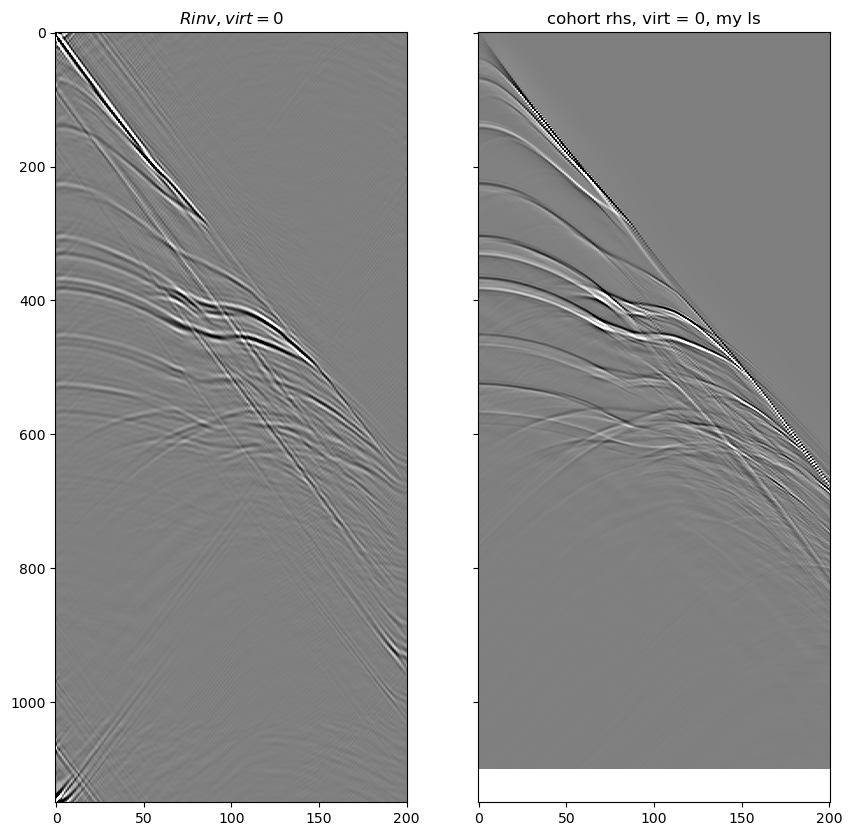

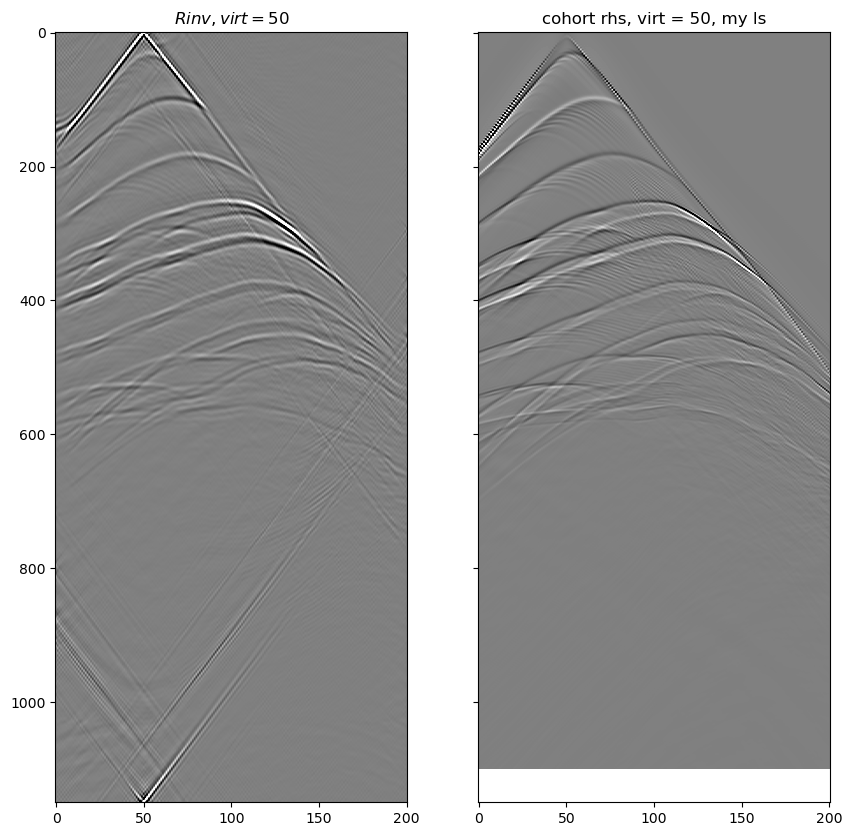

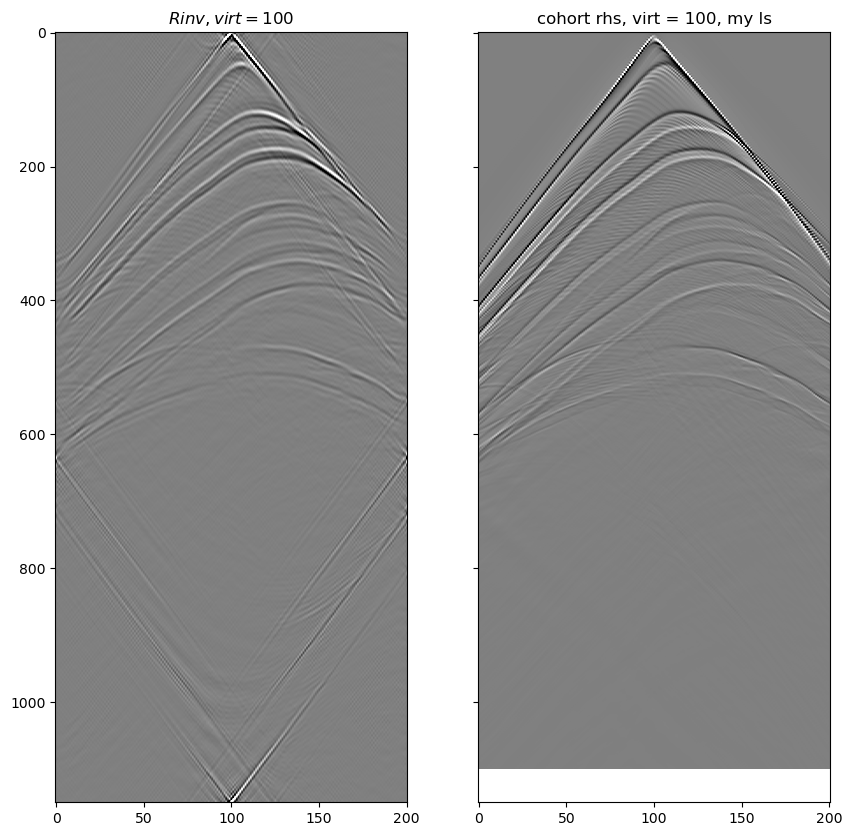

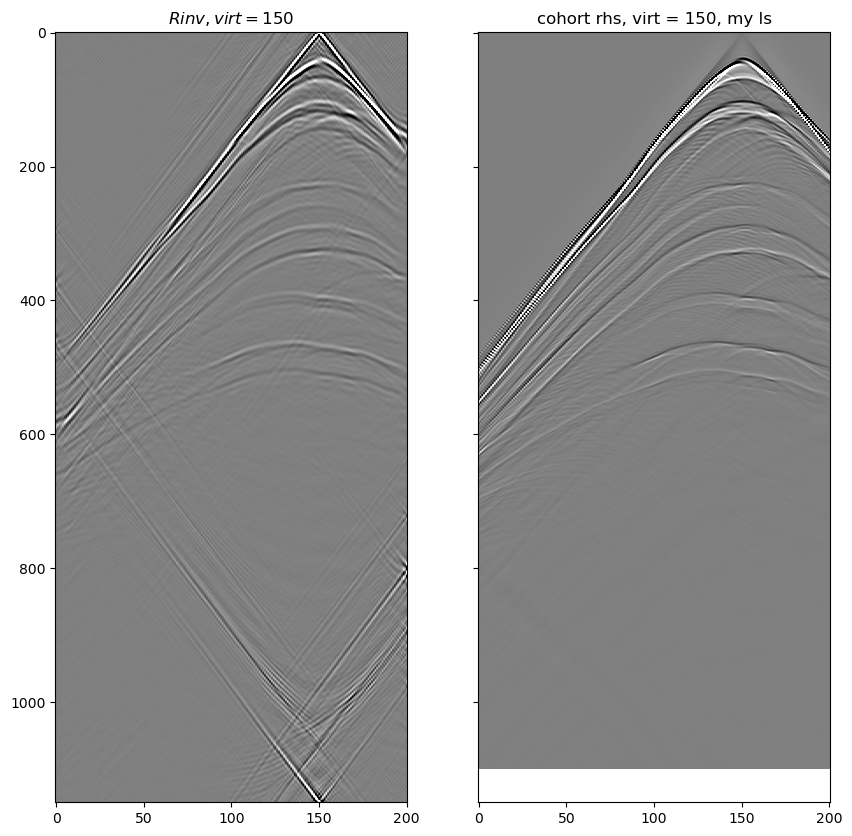

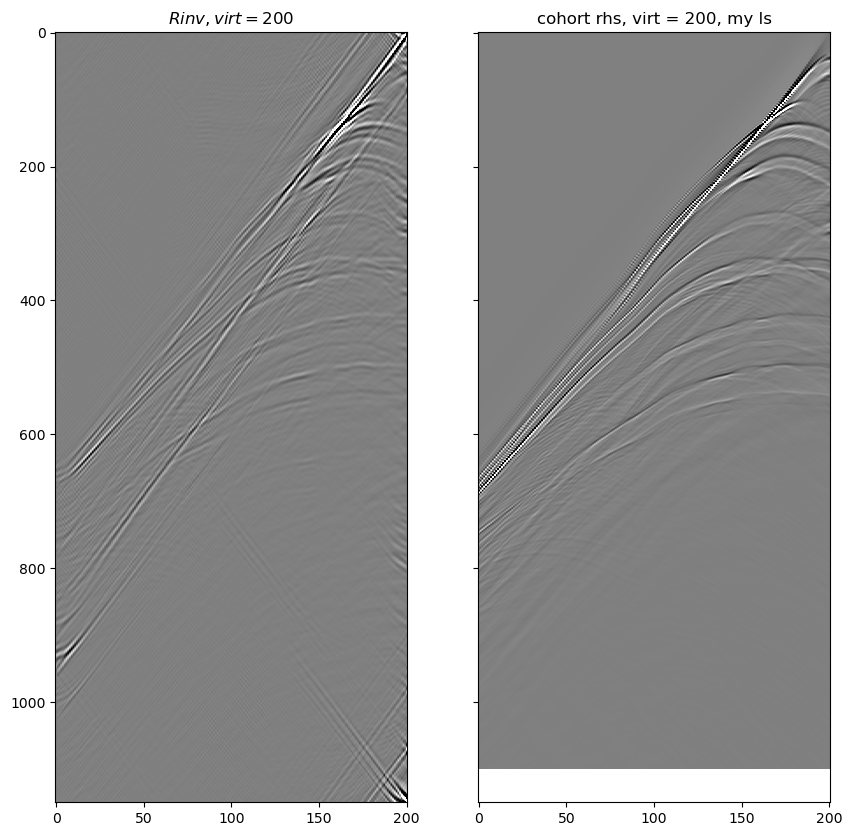

In [18]:
# plot
clip = 0.05
for iv in range(0, nv, 50):
    ig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 10))


    axs[1].imshow(x_true_t[:nt,:,iv], cmap='gray', vmin=-clip*np.abs(x_true_t).max(), vmax=clip*np.abs(x_true_t).max())
    axs[1].set_title(f'cohort rhs, virt = {iv}, my ls')
    axs[1].axis('tight')

    axs[0].imshow(x_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_t).max(), vmax=clip*np.abs(x_t).max())
    axs[0].set_title(f'$Rinv, virt = {iv}$')
    axs[0].axis('tight')
    

    plt.show()


### X=LR solver

In [20]:
# approximate rhs with rank r
r = 50

rhs_t = d.ravel().copy()
BLS_mat = np.zeros((ns*nfmax, r),dtype=complex)
BR_mat = np.zeros((r*nfmax, nv),dtype=complex)
BL_mat = np.zeros((ns*nfmax, r),dtype=complex)
BRS_mat = np.zeros((r*nfmax, nv),dtype=complex)
BLS_ten = np.zeros((nfmax, nr, r),dtype = complex)
BR_ten = np.zeros((nfmax, r, nv),dtype = complex)
BL_ten = np.zeros((nfmax, nr, r),dtype = complex)
BRS_ten = np.zeros((nfmax, r, nv),dtype = complex)
BS = np.zeros(r*nfmax, dtype = complex)
for ifr in range(nfmax):
    u,s,v = np.linalg.svd(rhs_fr[ifr,:,:])
    BLS_mat[ns*ifr:ns*(ifr+1),:] = u[:,:r] @ np.diag(s[:r])
    BR_mat[r*ifr:r*(ifr+1),:] = v[:r,:] 
    BL_mat[ns*ifr:ns*(ifr+1),:] = u[:,:r]
    BRS_mat[r*ifr:r*(ifr+1),:] = np.diag(s[:r]) @ v[:r,:] 
    BLS_ten[ifr,:,:] = u[:,:r] @ np.diag(s[:r])
    BR_ten[ifr,:,:] = v[:r, :]
    BL_ten[ifr,:,:] = u[:,:r]
    BRS_ten[ifr,:,:] =  np.diag(s[:r]) @ v[:r, :]
    BS[ifr*r:(ifr+1)*r] = s[:r]

In [21]:
x_true_t = R1.transpose(1, 0, 2).copy()

In [22]:
#test decomposition
print(np.linalg.norm(BLS_mat.ravel()-BLS_ten.ravel()),
np.linalg.norm(BRS_mat.ravel()-BRS_ten.ravel()),
np.linalg.norm(BL_mat.ravel()-BL_ten.ravel()),
np.linalg.norm(BR_mat.ravel()-BR_ten.ravel()))

0.0 0.0 0.0 0.0


In [23]:
Frop_r = Fredholm1(dr * dt * np.sqrt(nt) * Gfft, r, saveGt=saveGt, dtype=complex, usematmul=False)

In [24]:
t0 = time()
L_tmp = lsqr(Frop_r, BLS_ten.ravel(), damp=1e-10, iter_lim=iter_lim, show=1)[0]
L_tmp = L_tmp.reshape(nfmax, nr, r)
x_wr_f = np.zeros((nfmax, nr, nv),dtype = complex)
for ifr in range(nfmax):
    x_wr_f[ifr,:,:] = L_tmp[ifr,:,:] @ BR_ten[ifr,:,:]
x_wr_t = ((Fopf.H @ (IopHf @ x_wr_f.ravel())).real).reshape(nt, nr, nv)
t_wr = time() - t0
print (f'Time: {t_wr} sec')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2010000 rows and 2010000 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.090e+02  1.090e+02    1.0e+00  2.0e+00
     1  3.00214e-09   7.434e+01  7.434e+01    6.8e-01  5.8e-01   3.0e+02  1.0e+00
     2  8.01163e-09   5.600e+01  5.600e+01    5.1e-01  3.4e-01   4.2e+02  2.3e+00
     3  1.48355e-08   4.494e+01  4.494e+01    4.1e-01  2.7e-01   5.2e+02  3.9e+00
     4  2.27948e-08   3.742e+01  3.742e+01    3.4e-01  2.0e-01   6.0e+02  5.6e+00
     5  3.30812e-08   3.165e+01  3.165e+01    2.9e-01  1.6e-01   6.7e+02  7.5e+00
     6  4.30255e-08   2.820e+01  2.820e+01    2.6e-01  1.4e-01   7.3e+02  9.4e+00
     7  5.53360e-08   2.537e+01  2.537e+01    2.3e-01  1.1e-01   7.9e+02  1.1e+01
     8  6.82578e-08   2.340e

In [26]:
cut_off_t = 1100

0


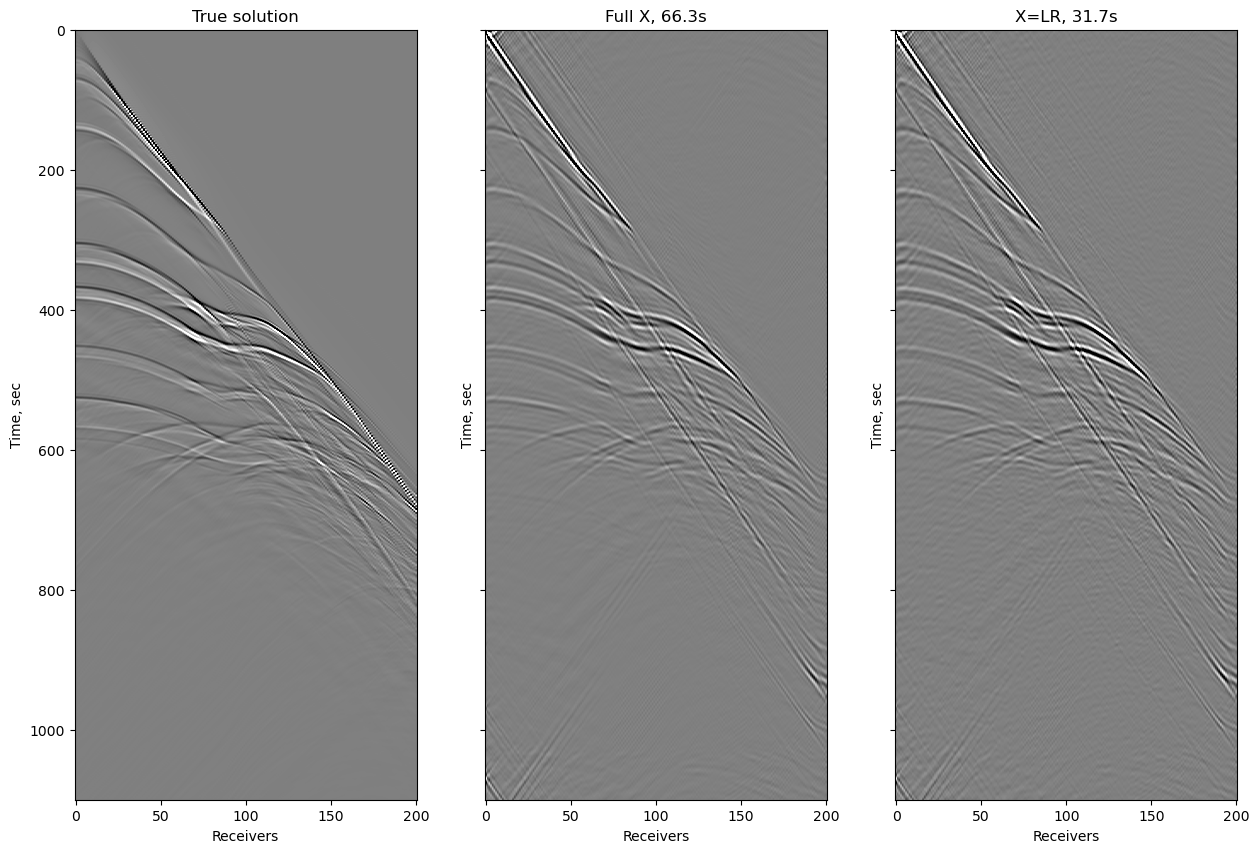

50


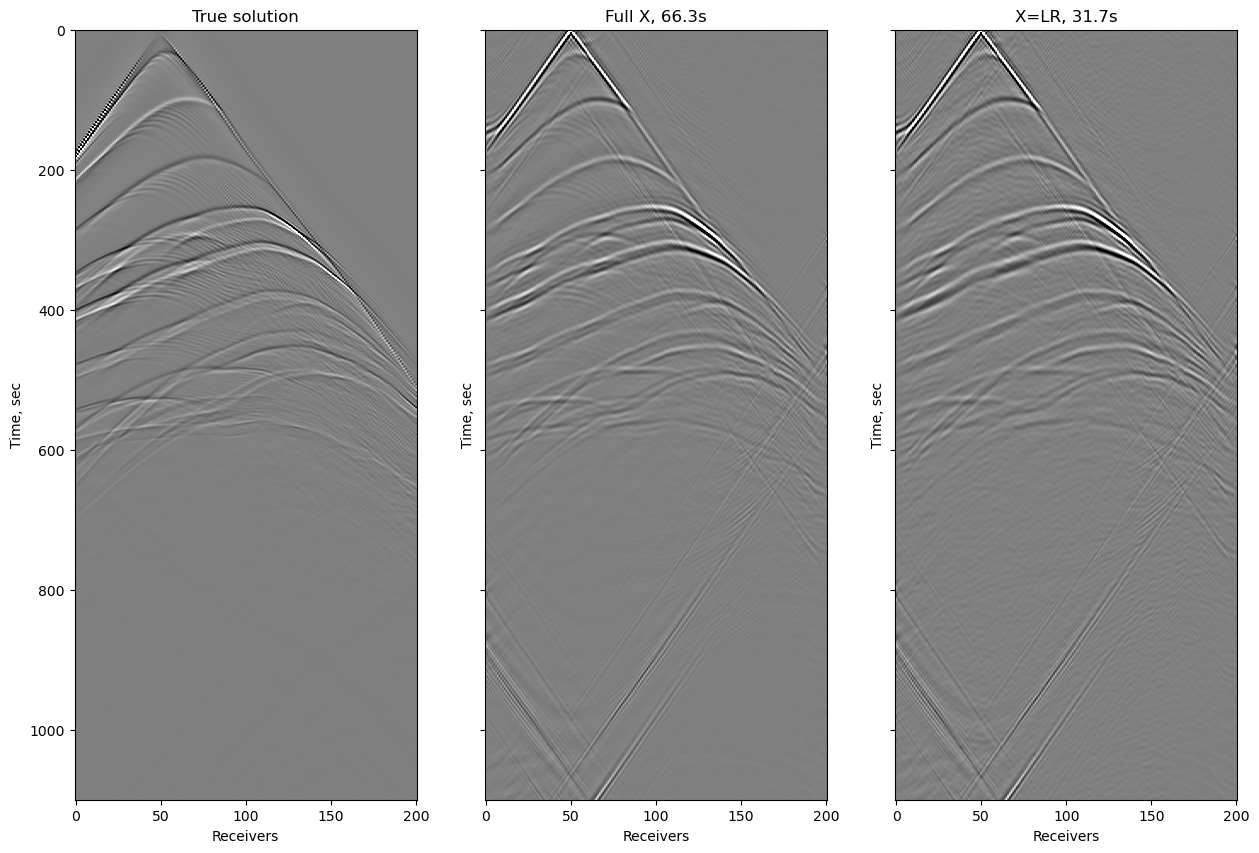

100


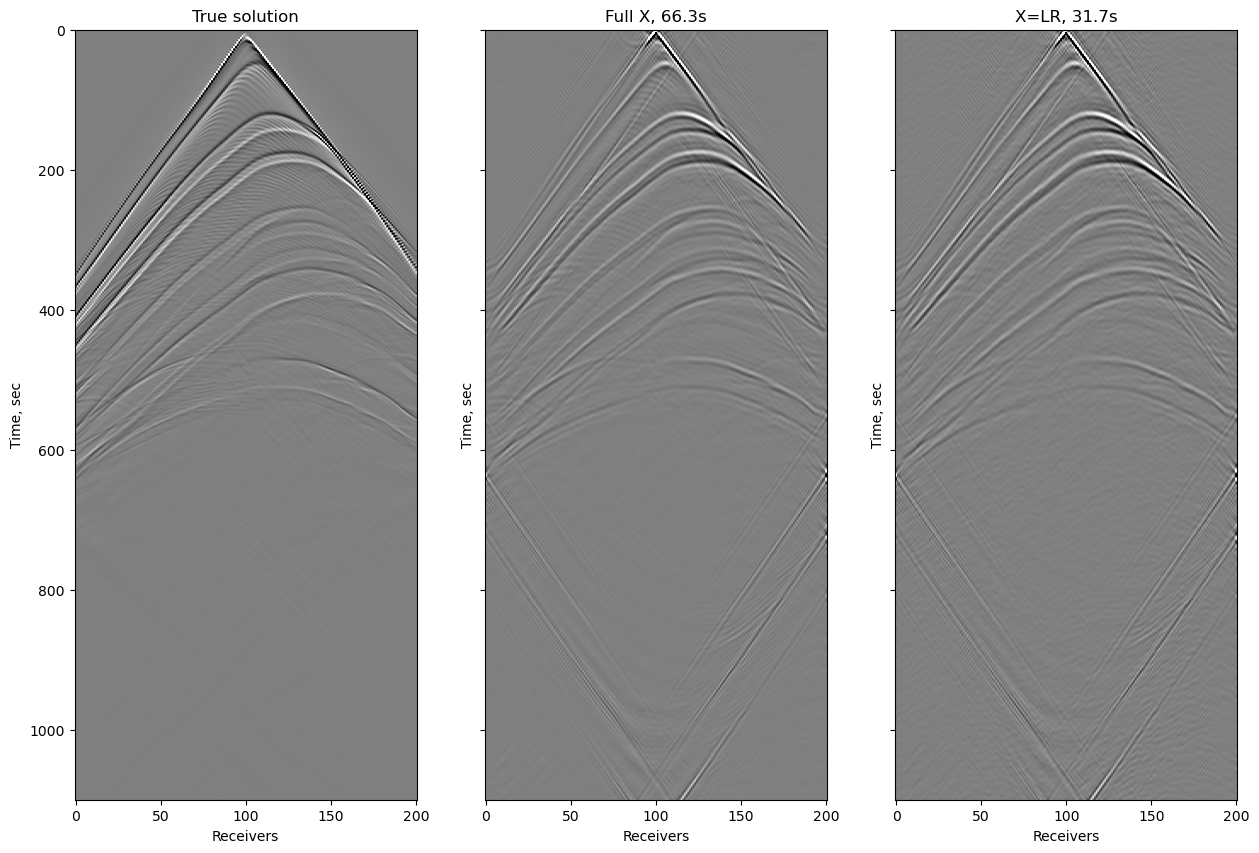

150


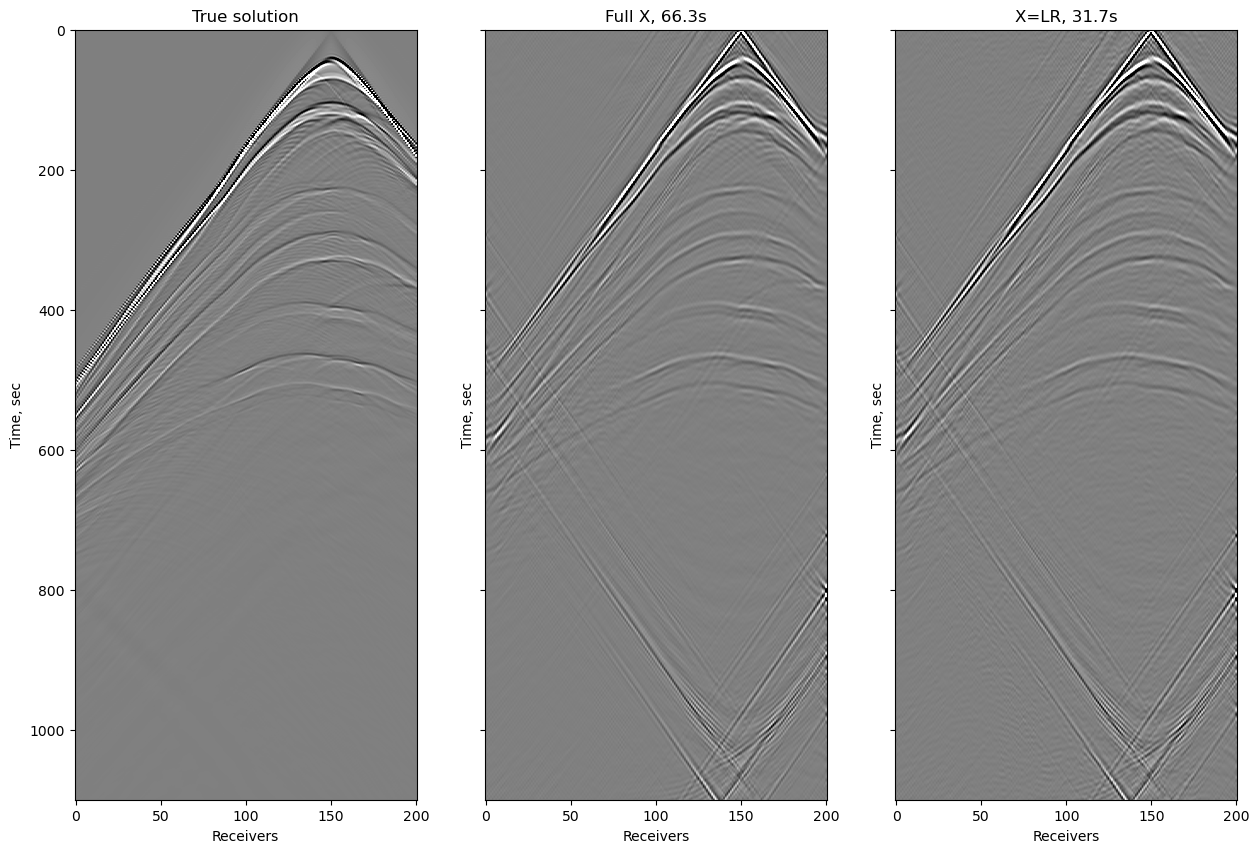

200


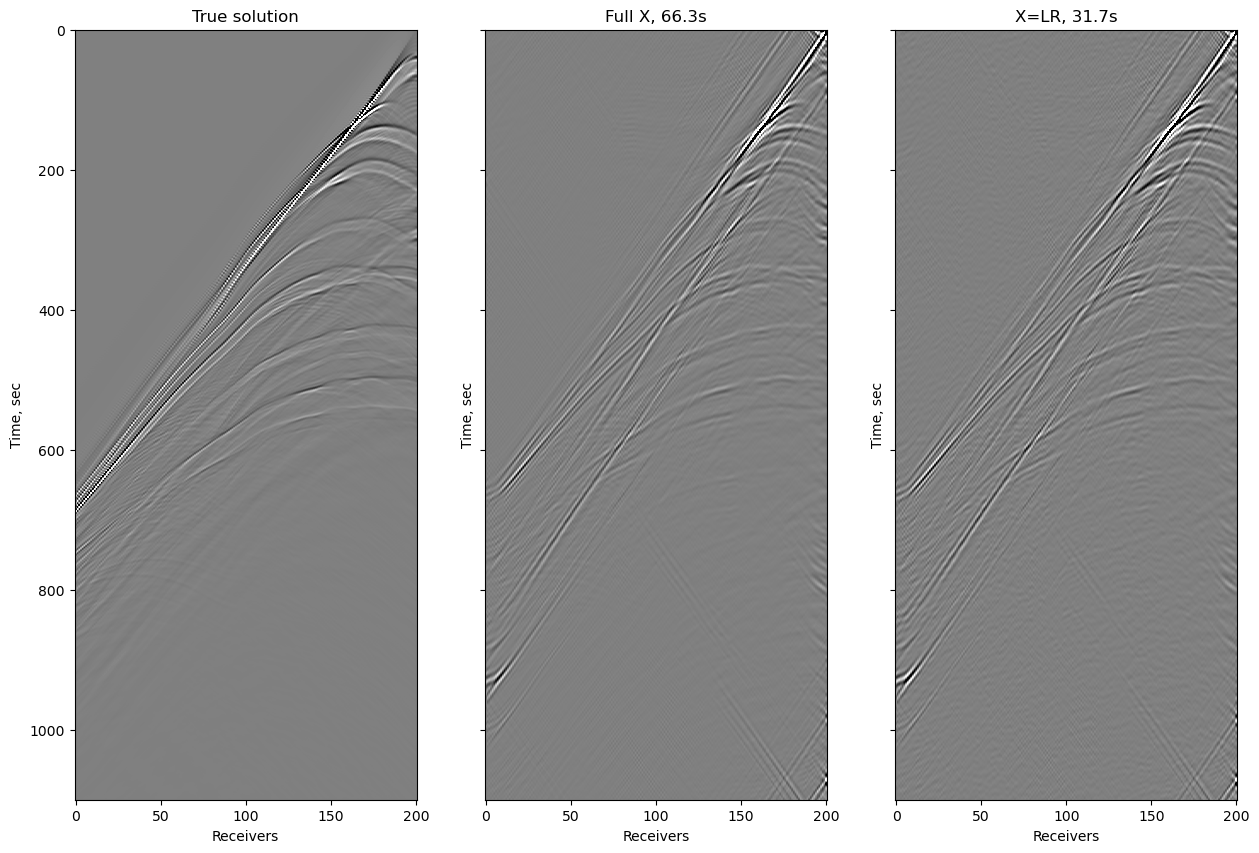

In [29]:
# plot
clip = 0.05
for iv in range(0, nv, 50):
    print (iv)
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 10))  
    ax[0].imshow(x_true_t[:cut_off_t,:,iv], cmap='gray', vmin=-clip*np.abs(x_true_t).max(), vmax=clip*np.abs(x_true_t).max())
    ax[0].set_title(f'True solution')
    ax[0].axis('tight')
    ax[0].set_xlabel('Receivers', fontsize=10)
    ax[0].set_ylabel('Time, sec', fontsize=10)
    
    ax[1].imshow(x_t[:cut_off_t,:,iv], cmap='gray', vmin=-clip*np.abs(x_t).max(), vmax=clip*np.abs(x_t).max())
    ax[1].set_title(f'Full X, {t_full:.1f}s')
    ax[1].axis('tight')
    ax[1].set_xlabel('Receivers', fontsize=10)
    ax[1].set_ylabel('Time, sec', fontsize=10)

    ax[2].imshow(x_wr_t[:cut_off_t,:,iv], cmap='gray', vmin=-clip*np.abs(x_wr_t).max(), vmax=clip*np.abs(x_wr_t).max())
    ax[2].set_title(f'X=LR, {t_wr:.1f}s')
    ax[2].axis('tight')
    ax[2].set_xlabel('Receivers', fontsize=10)
    ax[2].set_ylabel('Time, sec', fontsize=10)
    plt.show()
    if iv == 50:
        fig.savefig(f'../figs/ds1_lr')



## solve X = VSV^T

In [25]:
W_core = dr * dt * np.sqrt(nt) * Gfft
UWV_core =  np.zeros((nfmax, r, r), dtype = complex)
for ifr in range(nfmax):
    UWV_core[ifr,:,:] = BL_ten[ifr,:,:].conj().T @ W_core[ifr,:,:] @ BR_ten[ifr,:,:].T
UWV_sm = Fredholm1(UWV_core, r, saveGt=saveGt, dtype=complex, usematmul=False)

In [26]:
sig_rhs = np.zeros((nfmax*r,r),dtype=complex)
for ifr in range(nfmax):
    sig_rhs[ifr*r:(ifr+1)*r,:] = np.diag(BS[ifr*r:(ifr+1)*r])
sig_rhs_ten = np.zeros((nfmax,r,r),dtype=complex)
for ifr in range(nfmax):
    sig_rhs_ten[ifr, : ,:] = np.diag(BS[ifr*r:(ifr+1)*r])

In [27]:
t0 = time()
x_sig_sm_f = lsqr(UWV_sm, sig_rhs_ten.ravel() , damp=1e-10, iter_lim=iter_lim, show=1)[0]
t_vsv_sm = time() - t0
print (f'Time: {t_vsv_sm} sec')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 500000 rows and 500000 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.090e+02  1.090e+02    1.0e+00  1.7e+00
     1 -5.55220e-09   7.177e+01  7.177e+01    6.6e-01  6.4e-01   2.4e+02  1.0e+00
     2 -1.37660e-08   5.255e+01  5.255e+01    4.8e-01  3.6e-01   3.6e+02  2.3e+00
     3 -2.36241e-08   4.261e+01  4.261e+01    3.9e-01  2.5e-01   4.4e+02  3.8e+00
     4 -3.61946e-08   3.618e+01  3.618e+01    3.3e-01  1.8e-01   5.1e+02  5.4e+00
     5 -5.11603e-08   3.204e+01  3.204e+01    2.9e-01  1.4e-01   5.7e+02  7.2e+00
     6 -6.89460e-08   2.911e+01  2.911e+01    2.7e-01  1.1e-01   6.3e+02  9.1e+00
     7 -8.98060e-08   2.696e+01  2.696e+01    2.5e-01  1.0e-01   6.7e+02  1.1e+01
     8 -1.13247e-07   2.529e+0

In [28]:
x_sig_sm_f = x_sig_sm_f.reshape(nfmax, r, r)

In [29]:
x_vsv_sm_f = np.zeros((nfmax, nr, nv), dtype=complex)
for ifr in range(nfmax):
    x_vsv_sm_f[ifr,:,:] = BR_ten[ifr,:,:].T @ (x_sig_sm_f[ifr,:,:]) @ BR_ten[ifr,:,:]

In [30]:
x_vsv_sm_t = ((Fopf.H @ (Iopf.H @ x_vsv_sm_f.ravel())).real).reshape(nt, nr, nv)

In [43]:
# plot
clip = 0.05
c2 = 0.05
for iv in range(0, nv, 50):
    ig, axs = plt.subplots(1, 5, sharey=True, figsize=(20, 10))

    axs[0].imshow(x_vsv_sm_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_vsv_sm_t).max(), vmax=clip*np.abs(x_vsv_sm_t).max())
    axs[0].set_title(f'vsv, time: {t_vsv_sm:.1f} s')
    axs[0].axis('tight')

    axs[1].imshow(x_true_t[:nt,:,iv], cmap='gray', vmin=-clip*np.abs(x_true_t).max(), vmax=clip*np.abs(x_true_t).max())
    axs[1].set_title(f'frue')
    axs[1].axis('tight')

    axs[2].imshow(x_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_vsv_sm_t).max(), vmax=clip*np.abs(x_vsv_sm_t).max())
    axs[2].set_title(f'full, time:{t_full:.1f} s')
    axs[2].axis('tight')
    
    axs[3].imshow(x_vsv_sm_t[:nt,:,iv], cmap='gray', vmin=-clip*c2*np.abs(x_vsv_sm_t).max(), vmax=clip*c2*np.abs(x_vsv_sm_t).max())
    axs[3].set_title(f'vsv sym_prec, time: {t_vsv_re:.1f} s')
    axs[3].axis('tight')

    axs[4].imshow(x_wr_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_vsv_sm_t).max(), vmax=clip*np.abs(x_vsv_sm_t).max())
    axs[4].set_title(f'x=lr, time: {t_wr:.1f}')
    axs[4].axis('tight')

    
    plt.show()
